In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
sys.path.append("../..")

from xlstm_scaling_laws.analysis.fit_inference_time_model.objective_funcs import (
    InferenceModelObjectiveConfig,
    get_inference_time_model_objective_func,
)
from xlstm_scaling_laws.load_data.inference_time import load_inference_time_data
from xlstm_scaling_laws.fitting.common.run_fit import run_optimization, OptimizationConfig
from xlstm_scaling_laws.fitting.common.initialization import generate_initialization_sweep
from xlstm_scaling_laws.model_accounting.inference_time_model.llama_runtime_model import (
    predict_runtime_llama_step_time
)
import matplotlib.pyplot as plt
import seaborn as sns

# Fit the data of one model size and one batch size

This works for the simple linear_flops and linear_memops params.


In [2]:
ttft_df, step_time_df = load_inference_time_data("llama2")

In [3]:
step_time_df

model              input_params         measured_data  \
    model_type    model_tag    batchsize prefill    num_params   
0       llama2  llama2_160m            1       0     162220800   
1       llama2  llama2_160m            1     128     162220800   
2       llama2  llama2_160m            1     256     162220800   
3       llama2  llama2_160m            1     512     162220800   
4       llama2  llama2_160m            1    1024     162220800   
..         ...          ...          ...     ...           ...   
775     llama2    llama2_7b         1024    2048    6863196160   
776     llama2    llama2_7b         1024    4096    6863196160   
777     llama2    llama2_7b         1024    8192    6863196160   
778     llama2    llama2_7b         1024   12288    6863196160   
779     llama2    llama2_7b         1024   16384    6863196160   

                                                                     \
    memory_allocated_gl1 memory_reserved_gl1 memory_allocated_gl101   
0              651097600           675282944             1657730560   
1              684652544           715128832             1657731072   
2              718208000           757071872             1657732096   
3              751764480           828375040             1657734144   
4              785323008           872415232             1657738240   
..                   ...                 ...                    ...   
775                   -1                  -1                     -1   
776                   -1                  -1                     -1   
777                   -1                  -1                     -1   
778                   -1                  -1                     -1   
779                   -1                  -1                     -1   

                          model_params                           \
    memory_reserved_gl101    num_heads embedding_dim num_blocks   
0              3850371072         12.0         768.0       12.0   
1              3856662528         12.0         768.0       12.0   
2              3862953984         12.0         768.0       12.0   
3              3898605568         12.0         768.0       12.0   
4              3930062848         12.0         768.0       12.0   
..                    ...          ...           ...        ...   
775                    -1         32.0        4096.0       32.0   
776                    -1         32.0        4096.0       32.0   
777                    -1         32.0        4096.0       32.0   
778                    -1         32.0        4096.0       32.0   
779                    -1         32.0        4096.0       32.0   

                                                                     \
    ffn_proj_factor ffn_round_up_to_multiple_of vocab_size  ffn_dim   
0            2.6667                       128.0    50304.0   2048.0   
1            2.6667                       128.0    50304.0   2048.0   
2            2.6667                       128.0    50304.0   2048.0   
3            2.6667                       128.0    50304.0   2048.0   
4            2.6667                       128.0    50304.0   2048.0   
..              ...                         ...        ...      ...   
775          2.6667                       128.0    50304.0  11008.0   
776          2.6667                       128.0    50304.0  11008.0   
777          2.6667                       128.0    50304.0  11008.0   
778          2.6667                       128.0    50304.0  11008.0   
779          2.6667                       128.0    50304.0  11008.0   

    measured_data  
          runtime  
0        0.882568  
1        0.896712  
2        0.955145  
3         1.06588  
4        1.293715  
..            ...  
775           NaN  
776           NaN  
777           NaN  
778           NaN  
779           NaN  

[780 rows x 17 columns]

In [4]:
step_time_df[('model', 'model_tag')].unique()

array(['llama2_160m', 'llama2_400m', 'llama2_830m', 'llama2_1.4b',
       'llama2_2.7b', 'llama2_7b'], dtype=object)

In [5]:
model = "llama2_7b"
df = step_time_df.dropna()
df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]#[df[("input_params", "batchsize")] == 8]
data_df = df.copy()

/tmp/ipykernel_193224/4122109850.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]#[df[("input_params", "batchsize")] == 8]
/tmp/ipykernel_193224/4122109850.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]#[df[("input_params", "batchsize")] == 8]


In [6]:
data_df

model            input_params         measured_data  \
    model_type  model_tag    batchsize prefill    num_params   
681     llama2  llama2_7b            8     128    6863196160   
682     llama2  llama2_7b            8     256    6863196160   
683     llama2  llama2_7b            8     512    6863196160   
684     llama2  llama2_7b            8    1024    6863196160   
685     llama2  llama2_7b            8    2048    6863196160   
686     llama2  llama2_7b            8    4096    6863196160   
687     llama2  llama2_7b            8    8192    6863196160   
691     llama2  llama2_7b           16     128    6863196160   
692     llama2  llama2_7b           16     256    6863196160   
693     llama2  llama2_7b           16     512    6863196160   
694     llama2  llama2_7b           16    1024    6863196160   
695     llama2  llama2_7b           16    2048    6863196160   
696     llama2  llama2_7b           16    4096    6863196160   
701     llama2  llama2_7b           32     128    6863196160   
702     llama2  llama2_7b           32     256    6863196160   
703     llama2  llama2_7b           32     512    6863196160   
704     llama2  llama2_7b           32    1024    6863196160   
705     llama2  llama2_7b           32    2048    6863196160   
711     llama2  llama2_7b           64     128    6863196160   
712     llama2  llama2_7b           64     256    6863196160   
713     llama2  llama2_7b           64     512    6863196160   
714     llama2  llama2_7b           64    1024    6863196160   
721     llama2  llama2_7b          128     128    6863196160   
722     llama2  llama2_7b          128     256    6863196160   
723     llama2  llama2_7b          128     512    6863196160   
731     llama2  llama2_7b          256     128    6863196160   
741     llama2  llama2_7b          384     128    6863196160   

                                                                     \
    memory_allocated_gl1 memory_reserved_gl1 memory_allocated_gl101   
681          15108589056         19356712960            15108589056   
682          15108597248         19841155072            15108597248   
683          15108613632         21139292160            15108613632   
684          15108646400         23739760640            15108646400   
685          15108711936         28993126400            15108711936   
686          15108843008         39789264896            15108843008   
687          15109105152         61962452992            15109105152   
691          15108597248         19841155072            15108597248   
692          15108613632         21141389312            15108613632   
693          15108646400         23704109056            15108646400   
694          15108711936         28892463104            15108711936   
695          15108843008         39405486080            15108843008   
696          15109105152         60953722880            15109105152   
701          15108613632         21122514944            15108613632   
702          15108646400         23704109056            15108646400   
703          15108711936         28858908672            15108711936   
704          15108843008         39241908224            15108843008   
705          15109105152         60238594048            15109105152   
711          15108646400         23704109056            15108646400   
712          15108711936         28825354240            15108711936   
713          15108843008         39137050624            15108843008   
714          15109105152         59903049728            15109105152   
721          15108711936         28825354240            15108711936   
722          15108843008         39105593344            15108843008   
723          15109105152         59714306048            15109105152   
731          15108843008         39093010432            15108843008   
741          15108974080         49345986560            15108974080   

                          model_params                           \
    memory_reserved_gl101

In [7]:
optim_cfg = OptimizationConfig(
    objective_func_config=InferenceModelObjectiveConfig(
        huber_delta=100.,
        filter_zero_prefill=True,
        fit_data="step_time",
        fit_model="llama2",
        runtime_model_mode="log_linear_memops", #"linear_sum_flops_memops", #"linear_flops",
        bytes_act=2,
        bytes_Cmn=4,
        bytes_w=2,
        override_df=data_df,
        reduce_loss="none",
        squeeze_loos=True,  # Squeeze the loss to avoid issues with broadcasting
    ),
    scipy_optim_module="least_squares",
    method="lm",
    bootstrap_seed=0,
    num_bootstrap_samples=-1,
    # initialization_grid={
    #     "alpha": [900e12],
    #     "beta": [3.35e13],
    #     "rho": [1e-14],
    # },
    initialization_grid={
        # "beta": [1.0 * 3.35e17],
        "beta": [1.0 * 3.35e12],
        "eps": [1e-4],#[2e-3],
        "eps_bp": [1e-5],#[2e-3],

        # "beta": [np.log(1.5 * 3.35e13)],
        # "rho": [np.log(1e-14)],
    },
    tol=1e-15,
    other_optimization_kwargs=dict(
        xtol=1e-15,
        gtol=1e-15,
        # ftol=1e-14,
    )
)
print(optim_cfg.initialization_grid)

{'beta': [3350000000000.0], 'eps': [0.0001], 'eps_bp': [1e-05]}


In [8]:
optim_res_df = run_optimization(
    config=optim_cfg,
    objective_func_generator=get_inference_time_model_objective_func,
)

Running optimization: 100%|██████████| 1/1 [00:06<00:00,  6.68s/it]


In [9]:
optim_res_df.T

0
idxes         init_idx                                                       0
              bootstrap_idx                                                  0
optim_params  beta                                        1526813603139.829346
              eps                                                     0.005643
              eps_bp                                                  0.000232
optim_results loss           [5.755609656347521e-06, 1.1408995061172961e-06...
              message               `xtol` termination condition is satisfied.
              success                                                     True
              jac            [[-4.2541048249262835e-16, 0.07766908432292406...
              nfev                                                         139
              njev                                                        None
              status                                                         3
init_params   beta                                             3350000000000.0
              eps                                                       0.0001
              eps_bp                                                   0.00001

In [10]:
opt_params = optim_res_df.iloc[0, :]["optim_params"].to_dict()
# if optim_cfg.objective_func_config.runtime_model_mode.startswith("log_"):
#     opt_params = {k: float(np.exp(v)) for k, v in opt_params.items()}
print(opt_params)

{'beta': 1526813603139.8293, 'eps': 0.005642607712560831, 'eps_bp': 0.00023185628350415232}


In [11]:
# opt_params = {
#     "beta": 0.1 * 3.35e13,
#     "eps": 2e-3,
# }
# opt_params

In [12]:
pred_step_time_df = predict_runtime_llama_step_time(
    step_time_df=data_df.iloc[:, :],
    **opt_params,
    mode="linear_memops",
)

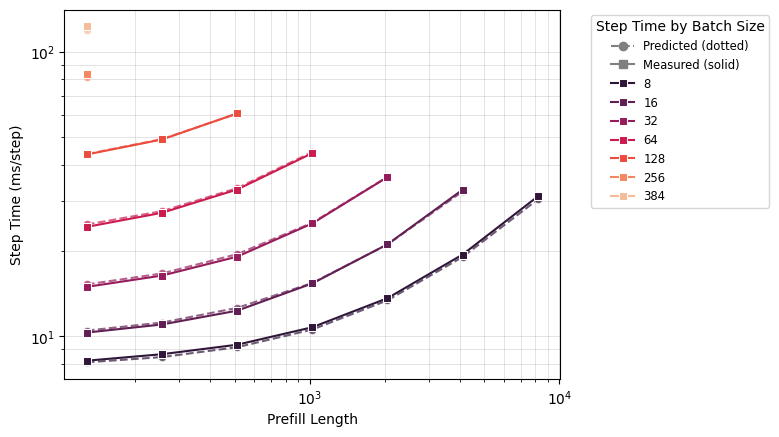

In [13]:
df = pred_step_time_df.copy()
# bs = 8
# df = df[df[("input_params", "batchsize")] == bs]

df = df[df[("model", "model_tag")] == model][df[("input_params", "batchsize")] < 2000]#[df[("input_params", "batchsize")] > 1]
df[("input_params", "batchsize")] = df[("input_params", "batchsize")].astype(str)
df[("pred", "runtime")] = df[("pred", "runtime")]
# ax = sns.lineplot(df, x=("input_params", "prefill"), y=('predicted_data', 'pred'), hue=("model", "model_tag"), markers=True, dashes=False)
ax = sns.lineplot(
    df,
    x=("input_params", "prefill"),
    y=("pred", "runtime"),
    hue=("input_params", "batchsize"),
    markers=True,
    dashes=False,
    marker="o",
    linestyle="--",
    alpha=0.7,
    palette="rocket",
    legend=False,
)
ax = sns.lineplot(
    df,
    x=("input_params", "prefill"),
    y=("measured_data", "runtime"),
    hue=("input_params", "batchsize"),
    markers=True,
    dashes=False,
    marker="s",
    legend="auto",
    palette="rocket",
)
ax.set_ylabel("Step Time (ms/step)")
ax.set_xlabel("Prefill Length")
# # ax = sns.lineplot(df, x=("input_params", "prefill"), y=('measured_data', 'runtime'), hue=('measured_data', 'num_params'), markers=True, dashes=False)
# Custom legend handles
import matplotlib.lines as mlines

dotted_line = mlines.Line2D(
    [], [], color="gray", linestyle="--", marker="o", label="Predicted (dotted)"
)
solid_line = mlines.Line2D(
    [], [], color="gray", linestyle="-", marker="s", label="Measured (solid)"
)
# header

# Existing legend handles (for batchsize)
handles, labels = ax.get_legend_handles_labels()

# Combine custom and existing handles
custom_handles = [dotted_line, solid_line]
ax.legend(
    custom_handles + handles,
    ["Predicted (dotted)", "Measured (solid)"] + labels,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    title="Step Time by Batch Size",
    fontsize="small",
)

# param_str = ", ".join([f"{k}={v:.2e}" for k, v in opt_params.items()])
# ax.set_title(f"Step Time Runtime Prediction for {model}: {param_str}")
ax.grid(True, which="both", ls="-", lw=0.5, alpha=0.5)
ax.set_yscale("log")
ax.set_xscale("log")
plt.savefig(os.path.join("plots", f"steptime_runtime_prediction_llama.pdf"), bbox_inches="tight", dpi=300)

In [14]:
eps_bps = []

for model in ["llama2_160m", "llama2_400m", "llama2_830m", "llama2_1.4b", "llama2_2.7b", "llama2_7b"]:

    df = step_time_df.dropna()
    df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]#[df[("input_params", "batchsize")] == 8]
    data_df = df.copy()

    optim_cfg = OptimizationConfig(
        objective_func_config=InferenceModelObjectiveConfig(
            huber_delta=100.,
            filter_zero_prefill=True,
            fit_data="step_time",
            fit_model="llama2",
            runtime_model_mode="log_linear_memops", #"linear_sum_flops_memops", #"linear_flops",
            bytes_act=2,
            bytes_Cmn=4,
            bytes_w=2,
            override_df=data_df,
            reduce_loss="none",
            squeeze_loos=True,  # Squeeze the loss to avoid issues with broadcasting
        ),
        scipy_optim_module="least_squares",
        method="lm",
        bootstrap_seed=0,
        num_bootstrap_samples=-1,
        # initialization_grid={
        #     "alpha": [900e12],
        #     "beta": [3.35e13],
        #     "rho": [1e-14],
        # },
        initialization_grid={
            # "beta": [1.0 * 3.35e17],
            "beta": [1.0 * 3.35e12],
            "eps": [1e-4],#[2e-3],
            "eps_bp": [1e-5],#[2e-3],

            # "beta": [np.log(1.5 * 3.35e13)],
            # "rho": [np.log(1e-14)],
        },
        tol=1e-15,
        other_optimization_kwargs=dict(
            xtol=1e-15,
            gtol=1e-15,
            # ftol=1e-14,
        )
    )

    optim_res_df = run_optimization(
        config=optim_cfg,
        objective_func_generator=get_inference_time_model_objective_func,
    )

    opt_params = optim_res_df.iloc[0, :]["optim_params"].to_dict()
    print(opt_params)
    eps_bps.append((model, opt_params["eps_bp"]))

/tmp/ipykernel_193224/805571291.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]#[df[("input_params", "batchsize")] == 8]
/tmp/ipykernel_193224/805571291.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]#[df[("input_params", "batchsize")] == 8]


Running optimization: 100%|██████████| 1/1 [00:07<00:00,  7.88s/it]
/tmp/ipykernel_193224/805571291.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]#[df[("input_params", "batchsize")] == 8]
/tmp/ipykernel_193224/805571291.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]#[df[("input_params", "batchsize")] == 8]


{'beta': 745471076416.3884, 'eps': 0.00105702011605575, 'eps_bp': 5.264322670447807e-06}


Running optimization: 100%|██████████| 1/1 [00:05<00:00,  5.04s/it]
/tmp/ipykernel_193224/805571291.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]#[df[("input_params", "batchsize")] == 8]
/tmp/ipykernel_193224/805571291.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]#[df[("input_params", "batchsize")] == 8]


{'beta': 813261349501.2731, 'eps': 0.0018237432735582777, 'eps_bp': 2.1984242754463366e-05}


Running optimization: 100%|██████████| 1/1 [00:12<00:00, 12.65s/it]
/tmp/ipykernel_193224/805571291.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]#[df[("input_params", "batchsize")] == 8]
/tmp/ipykernel_193224/805571291.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]#[df[("input_params", "batchsize")] == 8]


{'beta': 1168020348032.4873, 'eps': 0.0022222192553916042, 'eps_bp': 4.018147781140089e-05}


Running optimization: 100%|██████████| 1/1 [00:10<00:00, 10.42s/it]
/tmp/ipykernel_193224/805571291.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]#[df[("input_params", "batchsize")] == 8]
/tmp/ipykernel_193224/805571291.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]#[df[("input_params", "batchsize")] == 8]


{'beta': 1533785870725.3606, 'eps': 0.0024582685062382596, 'eps_bp': 6.0710367252327975e-05}


Running optimization: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]
/tmp/ipykernel_193224/805571291.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]#[df[("input_params", "batchsize")] == 8]
/tmp/ipykernel_193224/805571291.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]#[df[("input_params", "batchsize")] == 8]


{'beta': 977657235528.7977, 'eps': 0.0037369092478460554, 'eps_bp': 0.00013358676253131903}


Running optimization: 100%|██████████| 1/1 [00:06<00:00,  6.96s/it]

{'beta': 1526813603139.8293, 'eps': 0.005642607712560831, 'eps_bp': 0.00023185628350415232}


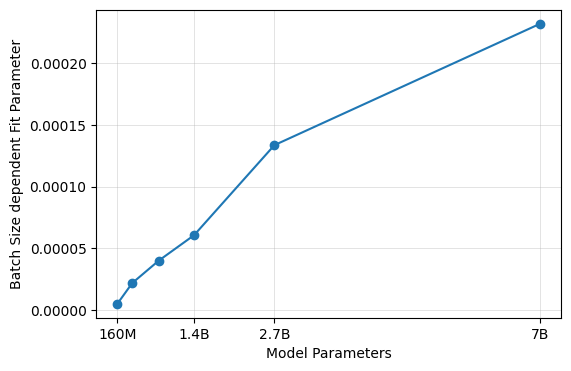

In [15]:
name_to_size = {
    "llama2_160m": 1.6e8,
    "llama2_400m": 4e8,
    "llama2_830m": 8.3e8,
    "llama2_1.4b": 1.4e9,
    "llama2_2.7b": 2.7e9,
    "llama2_7b": 7e9,
}

output = [(name_to_size[name], eps_bp) for name, eps_bp in eps_bps]

plt.figure(figsize=(6,4))
plt.plot(*zip(*output), marker="o")
plt.xticks([1.6e8, 1.4e9, 2.7e9, 7e9], ["160M", "1.4B", "2.7B", "7B"])
plt.grid(True, which="both", ls="-", lw=0.5)
# plt.xscale("log")
# plt.yscale("log")
plt.grid(True, which="both", ls="-", lw=0.5, alpha=0.5)
plt.xlabel("Model Parameters")
plt.ylabel("Batch Size dependent Fit Parameter")
plt.savefig(os.path.join("plots", f"steptime_runtime_fit_eps_bp_vs_model_size_llama.pdf"), bbox_inches="tight", dpi=300)